## Learning Manybody Wavefunction with Neural Network

The electronic wave function Ψ is a fundamental object in quantum physics and chemistry. In principle, exponential amount of information is required to solve for the exact, many-body electronic wave function. Therefore many different numerical approximations to the exact wave function has been brought up, among which Restricted Hartree-Fock (RHF) approximation is the simplest and most famous one.


In broader sense, finding good approximation to the many-body wave function resides in the realm of dimensionality reduction and feature extraction. This is essentially the same problem people are facing in data science. 

In this study, we will use artificial neural networks to learn a RHF wave function for a simple molecule, H2. We will also try to decide the optimal values for hyperparameters of our model. In the end, with the well-trained neural network, we will use it to predict one of the most important properties in chemistry, the density of electrons.

We also did the similar test for LiH. For sake of simplicity, I didn't include it here. Check the pdf report for more details.

# Part 1: Data exploration and cleanning
Read in the original data file and turn it into a 7*200020 Table.

The 7 colums are: x1,y1,z1 for the first H, x2,y2,z2 for the 2nd H, the wave funciton Ψ.

In [1]:
import numpy as np
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import matplotlib.cm as cm 

def read_data(file_name):
    """
    This function transfer the original txt file into a matrix txt file
    We only call this function once and it creates a matrix file
    We will use that matrix file as the input file after
    """
    with open(file_name) as f:
        content = f.readlines()
        
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    content = np.array(content)

    # get the first H position
    idx1 = np.arange(1, len(content), 4)
    pos1 = content[idx1] 
    xyz1 = np.array([i.split() for i in pos1])
    x1 = [float(i) for i in xyz1.T[0]]
    y1 = [float(i) for i in xyz1.T[1]]
    z1 = [float(i) for i in xyz1.T[2]]
    
    # get the second H position
    idx2 = np.arange(2, len(content), 4)
    pos2 = content[idx2] 
    xyz2 = np.array([i.split() for i in pos2])
    x2 = [float(i) for i in xyz2.T[0]]
    y2 = [float(i) for i in xyz2.T[1]]
    z2 = [float(i) for i in xyz2.T[2]]

    # get the psi
    idx3 = np.arange(3, len(content), 4)
    temp = content[idx3]
    psi = np.array([float(i.split()[1]) for i in temp])

    # write to a matrix file
    X = np.matrix([x1, y1, z1, x2, y2, z2, psi])
    np.savetxt('matrix_h2.txt', X)

    return len(x1)

N_data = read_data('h2.dat')
print('total number of data points: {0}'.format(N_data))

total number of data points: 2000200


# Part 2: Model Trainning
We use nulti-layer perceptron (MLP) in Sklearn package to fit our RHF data. For each molecule, 1.5 million samples are used to train the neural network and 0.5 million samples are then used to test the trained neural network. The overall training and testing error are plotted by averaging the training and testing error of 10 set of wave function samples. 

In [2]:
class fit_wfn():
    def __init__(self, data):
        # read the data: which is a n*7 matrix
        self.data = data 

    def fit(self, verbose=False):
        data = self.data

        # split into train and test data
        train = data.T[0:1500000]
        test = data.T[1500000:]
        x_train = train.T[0:6].T
        y_train = train.T[6].T
        x_test = test.T[0:6].T
        y_test = test.T[6].T
    
        # train the model
        mlp = MLPRegressor()
        mlp.hidden_layer_sizes = self.hidden_layer_sizes
        mlp.activation = self.activation
        mlp.solver = self.solver
        mlp.alpha = self.alpha
        mlp.fit(x_train, y_train)    
        self.mlp = mlp
        
        # predict
        y_train_p = mlp.predict(x_train)
        y_test_p = mlp.predict(x_test)
    
        # print training and test error
        train_error = np.mean((y_train - y_train_p)**2)
        test_error = np.mean((y_test - y_test_p)**2)
        if verbose:
            print(mlp.get_params())
            print("average training error is : %f" %(train_error))
            print("average test error is : %f" %(test_error))
        return train_error, test_error

    def predict(self,x):
        mlp = self.mlp
        return mlp.predict(x)

The following is an example showing how we call the funciton

In [3]:
data = np.loadtxt('matrix_h2.txt')
wfn = fit_wfn(data)
wfn.hidden_layer_sizes = (100,1)
wfn.activation = 'relu'
wfn.solver = 'adam'
wfn.alpha = 0.0001
train_error, test_error = wfn.fit()

Now, lets's try to find the optimal layer size with cross-validation, the minimum test error.

In the following figure, we plot the training and testing error of our neural network as a function of different layers and different number of neurons per layer for H2. As we see in the plot, when the number of layers and the number of neurons per layer increases, both the training and testing error goes down. This is due to the increase of the model representability as the number of parameters increases. In all cases we test, we don’t observe an increase of testing error in accompany with decreasing of training error, indicting that our neural network is correctly learning the true pattern of the wave function without hitting the overfitting problem. We therefore conclude that for H2, our simple neural network is ca- pable of learning the correct wave function.

Based on this plot, we decide to use (100,3) for the layer size.

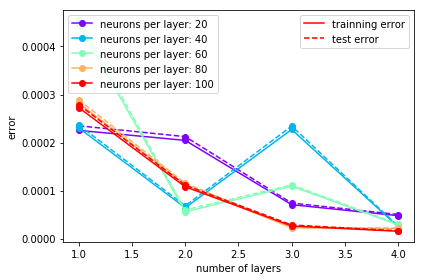

In [4]:
neurons = [20,40,60,80,100]
layers = [1,2,3,4]
loops = 10
train_errors = np.zeros((len(neurons), loops, len(layers)))
test_errors = np.zeros((len(neurons), loops, len(layers)))
colors = cm.rainbow(np.linspace(0, 1, len(neurons)))

# go through nerurons and layers, calculate train and test error
for i,neuron in enumerate(neurons):
    for j in range(loops):
        for k,layer in enumerate(layers):
            wfn.hidden_layer_sizes = (neuron,layer)
            train_errors[i,j,k], test_errors[i,j,k] = wfn.fit() 
    plt.plot(layers, np.mean(train_errors[i], axis=0), 'o-', c=colors[i], 
                label='neurons per layer: %d' %neuron)
    plt.plot(layers, np.mean(test_errors[i], axis=0), 'o--', c=colors[i])

lgd1 = plt.legend(loc='upper left')
l1, = plt.plot([],'r-', label='trainning error')
l2, = plt.plot([],'r--', label='test error')
plt.gca().add_artist(lgd1)
plt.legend(handles=[l1,l2], loc='upper right')
plt.xlabel('number of layers')
plt.ylabel('error')
plt.tight_layout()
plt.savefig('error_layer_size_h2.png')

# Part 3: Plot the Electron Probability Density for H2
Based on the testing error, We choose 3-layer and 100-neuron-per-layer as optimal hyperparameter since the testing error is at its minimal when such an architecture is applied. With neural network trained using such parameters for H2. We compute wave function |Ψ|2, the probability density of electrons, on a 2-dimensional grid. The x and y axis of the 2D grid represents the position of first and second electron. We only plot |Ψ|2 value along x-direction of electrons position since the hydrogen atoms are aligned on this axis. 

In [5]:
# the best fit neural nets params
wfn.hidden_layer_sizes = (100,3)
wfn.fit()

# predict data: Put both electrons only on x axis, range from -5 to 5
# the y, z position would be 0
x1 = np.linspace(-5,5,500)
x2 = np.linspace(-5,5,500)
xx1, xx2 = np.meshgrid(x1, x2)
xx1_1d = xx1.ravel()
xx2_1d = xx2.ravel()
y = np.zeros(len(xx1_1d))
z = np.zeros(len(xx1_1d))
X = np.array([xx1_1d,y,z,xx2_1d,y,z]).T

# predict their psi
y_1d = wfn.predict(X)
y = np.reshape(y_1d,(len(x1), len(x2)))


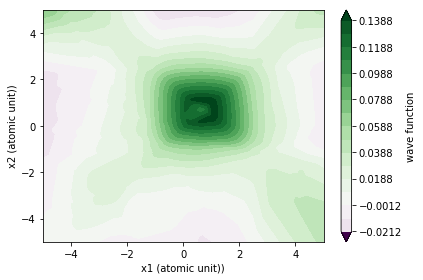

In [11]:
# plot the contour of psi
cmap = cm.PRGn
norm = cm.colors.Normalize(vmax=abs(y).max(), vmin=-abs(y).max())
levels = np.arange(y.min(), y.max(), 0.01)
plt.contourf(xx1, xx2, y, levels,cmap=cm.get_cmap(cmap, len(levels) - 1), norm=norm, extend='both')
plt.xlabel('x1 (atomic unit))')
plt.ylabel('x2 (atomic unit))')
cb = plt.colorbar()
cb.set_label('wave function')
plt.tight_layout()
plt.show()

The predicted electronic density is shown in the plot above.
As we can see in the plot, the electron density is peaked in the range where the positions of both electrons are between 0 and 1. 
This is as expected since first we know that these two electrons form chemical bond in H2. 
In order to do so, they need to be in the same location to allow enough overlap of their wave function. 
As a result, we see the electron density is peaked at where the positions of two electrons are similar.

Secondly, since the two hydrogen atoms are located one at origin and another one around 1.5 atomic unit, 
we do see the electron density peaks in such area. 
Therefore our neural network successfully learn the physical feature that electrons need to be attracted by nuclei.


# Part 4: Apply similar test to another molecular: LiH




In [16]:
def read_data(file_name):
    """
    This function transfer the original txt file into a matrix txt file
    We only call this function once and it creates a matrix file
    We will use that matrix file as the input file after
    """
    with open(file_name) as f:
        content = f.readlines()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content] 
    content = np.array(content)

    # get the first H position
    idx1 = np.arange(1, len(content), 6)
    pos1 = content[idx1] 
    xyz1 = np.array([i.split() for i in pos1])
    x1 = [float(i) for i in xyz1.T[0]]
    y1 = [float(i) for i in xyz1.T[1]]
    z1 = [float(i) for i in xyz1.T[2]]
    
    # get the second H position
    idx2 = np.arange(2, len(content), 6)
    pos2 = content[idx2] 
    xyz2 = np.array([i.split() for i in pos2])
    x2 = [float(i) for i in xyz2.T[0]]
    y2 = [float(i) for i in xyz2.T[1]]
    z2 = [float(i) for i in xyz2.T[2]]

    # get the third H position
    idx3 = np.arange(3, len(content), 6)
    pos3 = content[idx3] 
    xyz3 = np.array([i.split() for i in pos3])
    x3 = [float(i) for i in xyz3.T[0]]
    y3 = [float(i) for i in xyz3.T[1]]
    z3 = [float(i) for i in xyz3.T[2]]

    # get the second H position
    idx4 = np.arange(4, len(content), 6)
    pos4 = content[idx4] 
    xyz4 = np.array([i.split() for i in pos4])
    x4 = [float(i) for i in xyz4.T[0]]
    y4 = [float(i) for i in xyz4.T[1]]
    z4 = [float(i) for i in xyz4.T[2]]

    # get the psi
    idx5 = np.arange(5, len(content), 6)
    temp = content[idx5]
    psi = np.array([float(i.split()[1]) for i in temp])

    # write to a matrix file
    X = np.matrix([x1, y1, z1, x2, y2, z2, x3, y3, z3, x4, y4, z4, psi])
    np.savetxt('matrix_lih.txt', X)

    return len(x1)


# first read the data
N_data = read_data('lih.dat')
print('total number of data points: {0}'.format(N_data))


total number of data points: 2000200


In [17]:
# fit the data:
class fit_wfn():
    def __init__(self, data):
        # read the data: which is a n*13 matrix
        self.data = data 

    def fit(self, verbose=False):
        data = self.data

        # split into train and test data
        train = data.T[0:1500000]
        test = data.T[1500000:]
        x_train = train.T[0:12].T
        y_train = train.T[12].T
        x_test = test.T[0:12].T
        y_test = test.T[12].T
    
        # train the model
        mlp = MLPRegressor()
        mlp.hidden_layer_sizes = self.hidden_layer_sizes
        mlp.activation = self.activation
        mlp.solver = self.solver
        mlp.alpha = self.alpha
        mlp.fit(x_train, y_train)    
        self.mlp = mlp
        
        # predict
        y_train_p = mlp.predict(x_train)
        y_test_p = mlp.predict(x_test)
    
        # print training and test error
        train_error = np.mean((y_train - y_train_p)**2)
        test_error = np.mean((y_test - y_test_p)**2)
        if verbose:
            print(mlp.get_params())
            print("average training error is : %f" %(train_error))
            print("average test error is : %f" %(test_error))
        return train_error, test_error

    def predict(self,x):
        mlp = self.mlp
        return mlp.predict(x)



In [20]:
data = np.loadtxt('matrix_lih.txt')
wfn = fit_wfn(data)
wfn.hidden_layer_sizes = (100,1)
wfn.activation = 'relu'
wfn.solver = 'adam'
wfn.alpha = 0.0001
train_error, test_error = wfn.fit()



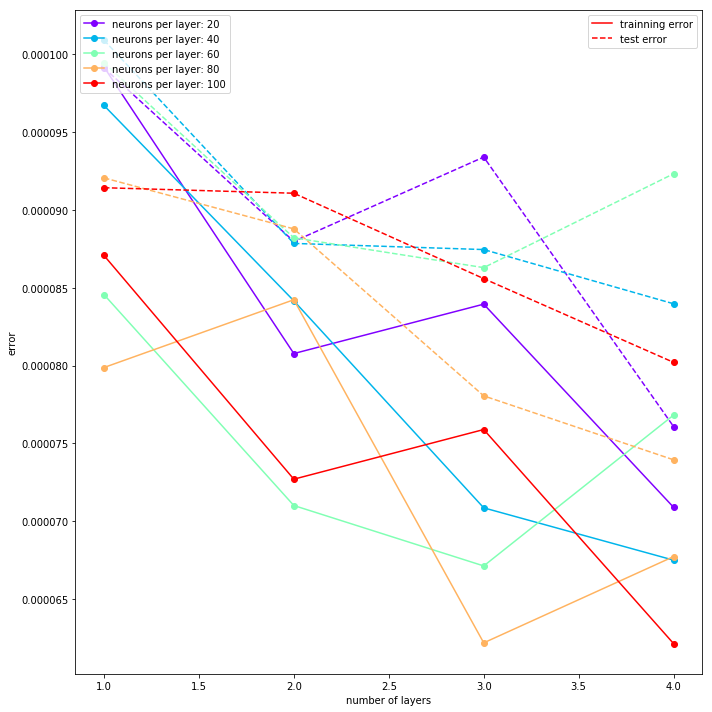

In [23]:
plt.figure(figsize=(10,10))
for i,neuron in enumerate(neurons):
    for j in range(loops):
        for k,layer in enumerate(layers):
            wfn.hidden_layer_sizes = (neuron,layer)
            train_errors[i,j,k], test_errors[i,j,k] = wfn.fit() 
    plt.plot(layers, np.mean(train_errors[i], axis=0), 'o-', c=colors[i], 
                label='neurons per layer: %d' %neuron)
    plt.plot(layers, np.mean(test_errors[i], axis=0), 'o--', c=colors[i])

lgd1 = plt.legend(loc='upper left')
l1, = plt.plot([],'r-', label='trainning error')
l2, = plt.plot([],'r--', label='test error')
plt.gca().add_artist(lgd1)
plt.legend(handles=[l1,l2], loc='upper right')
plt.xlabel('number of layers')
plt.ylabel('error')
plt.tight_layout()
plt.savefig('error_layer_size_lih.png')


We found that for H2 both the training and testing error are extremely small and no overfitting problem is observed as our model gets more and more complicated. 
However, for LiH we found the training and testing error are significantly larger and the overfitting problem starts to emerge.
